<a href="https://colab.research.google.com/github/Smasko7/Poverty-Prediction-Challenge/blob/main/Final_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from scipy import stats
from sklearn import tree
import itertools
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor

# Load the necessary datasets

We load the datasets and the labels that the competition provides. Also, we load the preprocessed data that have been created from the Poverty_EDA_and_Preprocessing.ipynb colab file.

In [5]:
df_original = pd.DataFrame(pd.read_csv("train_hh_features.csv"))
labels_df = pd.DataFrame(pd.read_csv("train_hh_gt.csv"))
df_copy_scaled = pd.DataFrame(pd.read_csv("Preprocessed_train_data.csv"))
actual_rates = pd.read_csv("train_rates_gt.csv")

y = labels_df['cons_ppp17']
X = df_copy_scaled
weights = df_original['weight']
survey_ids = df_original['survey_id']

## Calculate poverty rates from consumption predictions

In [2]:
def calculate_poverty_rates(df, consumption_col='cons_ppp17', weight_col='weight'):
    """Calculates weighted poverty rates based on predictions in df."""
    thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
                  9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]
    results = []

    for survey_id in df['survey_id'].unique():
        survey_data = df[df['survey_id'] == survey_id]
        total_weight = survey_data[weight_col].sum()
        row = {'survey_id': int(survey_id)}

        for t in thresholds:
            # We use the prediction column here for the scorer logic
            is_below = (survey_data[consumption_col] < t).astype(int)
            weighted_poverty_rate = (is_below * survey_data[weight_col]).sum() / total_weight
            row[f'pct_hh_below_{t:.2f}'] = weighted_poverty_rate

        results.append(row)

    return pd.DataFrame(results)

## Function that calculates competition metric (90% poverty rates MAPE + 10% consumption MAPE)

The function below calculates the wS-wMAPE metric, which is the official competition metric. This metric is a combination of 2 weighted sums, including the weighted MAPE of poverty rates and consumption values. More information on the project description.
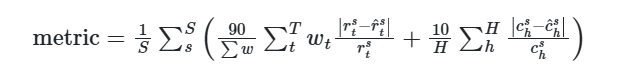

In [3]:
def competition_metric(y_true, y_pred, weights, survey_ids, actual_poverty_rates=None, metric = 'comp_score'):
    """
    Calculates the 90/10 blended Weighted MAPE used by the competition, if metric = 'comp_score'.
    Calculates the consumption MAPE, if metric = 'consumption_score'.
    Calculates the average weighted poverty rates MAPE, if metric = 'pov_rates_score'.
    """

    # Poverty Rate Weighted MAPE (90%)
    # Calculate predicted rates for these y_pred
    pred_rates_df = calculate_poverty_rates(pd.DataFrame({
        'survey_id': survey_ids.values,
        'cons_ppp17': y_pred,
        'weight': weights.values
    }))


    y_true_df = pd.DataFrame({
        'survey_id': survey_ids.values,
        'y_true': y_true
    })

    y_pred_df = pd.DataFrame({
        'survey_id': survey_ids.values,
        'y_pred': y_pred
    })


    thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
                  9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]
    percentile_ranks = np.arange(0.05, 1.0, 0.05) # 5%, 10% ... 95%
    rho_p = 1 - np.abs(percentile_ranks - 0.40)
    rho_p_norm = rho_p / rho_p.sum()

    comp_score_list = []
    cons_list = []
    poverty_rates_list = []

    for s_id in pred_rates_df['survey_id'].unique():
        s_true_rates = actual_poverty_rates[actual_poverty_rates['survey_id'] == s_id].iloc[0, 1:].values
        s_pred_rates = pred_rates_df[pred_rates_df['survey_id'] == s_id].iloc[0, 1:].values

        s_true_cons = y_true_df[y_true_df['survey_id'] == s_id]['y_true']
        s_pred_cons = y_pred_df[y_pred_df['survey_id'] == s_id]['y_pred']

        mape_p = np.abs((s_true_rates - s_pred_rates) / s_true_rates)
        weighted_mape_p = np.sum(mape_p * rho_p_norm)

        mape_cons = mean_absolute_percentage_error(s_true_cons, s_pred_cons)

        survey_score = (90 * weighted_mape_p) + (10 * mape_cons)

        comp_score_list.append(survey_score)
        cons_list.append(10*mape_cons)
        poverty_rates_list.append(100*weighted_mape_p)

    competition_score = np.mean(comp_score_list)
    avg_w_mape_poverty = np.mean(poverty_rates_list)
    mape_cons = np.mean(cons_list)

    # print(f"Competition Metric: {competition_score}")
    # print(f"Weighted Consumption MAPE: {mape_cons:.4f}")
    # print(f"Poverty Rate Weighted: {avg_w_mape_poverty:.4f}")

    if metric == 'pov_rates_score':
        return avg_w_mape_poverty
    elif metric == 'consumption_score':
        return mape_cons
    else:
        return competition_score

## Function of a custom scorer of the competition metric, to evaluate the GridSearch models

In [4]:
def get_competition_scorer(weights, survey_ids, actual_poverty_rates, metric = 'competition_score'):
    def scorer(estimator, X, y):
        # Inverse log-transform is handled by TransformedTargetRegressor automatically
        y_pred = estimator.predict(X)

        # Align survey_ids and weights with the current validation fold X
        indices = X.index
        s_ids_fold = survey_ids.loc[indices]
        weights_fold = weights.loc[indices]

        return -competition_metric(y, y_pred, weights_fold, s_ids_fold, actual_poverty_rates, metric)
    return scorer

# Find Final Models

As we have seen in Train_Models.ipynb, the most efficient model for this competition's regression task is xgboost, thus we are going to further fine-tune it.

Also, we observe the **necessity of 2 separate models for the 2 separate regression tasks** (consumption per household and overall poverty rates). Only one model that first predicts the consumption and then derives the poverty rates is highly unlikely to perform well on both tasks.

As a result, we first apply a grid search of **xgboost model**, with datasets' weights taken into consideration as sample_weights, with the goal **to minimize the weighted MAPE of poverty rates** (secondary competetition metric). This metric plays a decisive role in the final competition metric, as it affects the 90% of the final metric.

**For the second task** (predict consumption: 'consppp17'), we will try to fine-tune the **CatBoost model**, to yield even better results. It is mentioned that the datasets' weights should not be taken into account in fit() function this time, because predicting consumption is conducted per household. This trick will result to even better performance and lower metrics.

## XGBoost for first task (predict poverty rates)

It is noted that the poverty rates are derived from the consumption predictions, by the calculate_poverty_rates function. Thus, the xgboost model should inevitably predict, first, the consumption values and then extract the poverty rates. These poverty rates will be submitted in the competition. However, the consumption predictions (2nd task), that led to finding the poverty rates, will not be sumbitted, as the performance will be poor. For the second task, Catboost without weights is selected.

In [ ]:
from xgboost import XGBRegressor

def run_xgb_search(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    base_xgb = XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_estimators=100
    )

    model = TransformedTargetRegressor(
        regressor=base_xgb,
        func=np.log1p,
        inverse_func=np.expm1
    )

    param_grid = {
        'regressor__max_depth': [8, 9, 10, 12, 13, 15],
        'regressor__learning_rate': [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9],
        'regressor__subsample': [0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9]
    }

    cv_strategy = GroupKFold(n_splits=3)

    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=my_scorer,
        verbose=1,
        n_jobs=1
    )

    print("Beginning XGBoost Search Optimized for Poverty Rates Metric...")
    grid.fit(X, y, groups=survey_ids, sample_weight=weights)

    # EXTRACT AND PRINT METRICS
    results_df = pd.DataFrame(grid.cv_results_)
    tracking_report = results_df[[
        'params',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]].copy()

    tracking_report['mean_blended_error'] = -tracking_report['mean_test_score']
    tracking_report = tracking_report.sort_values('rank_test_score')

    print("\n" + "="*50)
    print("DETAILED XGBOOST GRID SEARCH REPORT")
    print("="*50)
    print(tracking_report.to_string(index=False))
    print("="*50)

    tracking_report.to_csv("xgb_grid_search_metrics_log.csv", index=False)

    print(f"Best Score (Neg) {scorer_metric}: {grid.best_score_:.4f}")
    print(f"Optimal Params: {grid.best_params_}")

    return grid.best_estimator_


scorer_metric = 'pov_rates_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
best_model_xgb = run_xgb_search(X, y, weights, survey_ids, actual_rates, scorer_metric)

Beginning XGBoost Search Optimized for Poverty Rates Metric...
Fitting 3 folds for each of 294 candidates, totalling 882 fits

DETAILED XGBOOST GRID SEARCH REPORT
                                                                                      params  mean_test_score  std_test_score  rank_test_score  mean_blended_error
 {'regressor__learning_rate': 0.5, 'regressor__max_depth': 12, 'regressor__subsample': 0.55}        -1.145457        0.416634                1            1.145457
  {'regressor__learning_rate': 0.7, 'regressor__max_depth': 12, 'regressor__subsample': 0.8}        -1.257191        0.358216                2            1.257191
  {'regressor__learning_rate': 0.6, 'regressor__max_depth': 13, 'regressor__subsample': 0.7}        -1.315183        0.542900                3            1.315183
  {'regressor__learning_rate': 0.65, 'regressor__max_depth': 9, 'regressor__subsample': 0.7}        -1.441298        0.783109                4            1.441298
  {'regressor__learnin

Thus, the optimal parameters for xgboost (for poverty rates prediction) are:

{'regressor__learning_rate': 0.5, 'regressor__max_depth': 12, 'regressor__subsample': 0.55}

And the mean validation poverty rates score is 1.1455

## Run single, best xgboost model

In [34]:
from sklearn.model_selection import cross_validate

def run_single_xgb(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    base_xgb = XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_estimators=100,
        learning_rate=0.5,
        max_depth=12,
        subsample=0.55
    )

    model = TransformedTargetRegressor(
        regressor=base_xgb,
        func=np.log1p,
        inverse_func=np.expm1
    )

    cv_strategy = GroupKFold(n_splits=3)
    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)

    cv_results = cross_validate(
        model, X, y,
        groups=survey_ids,
        params={'sample_weight': weights}, # Pass weights to the fit method
        scoring=my_scorer,
        cv=cv_strategy
    )

    mean_error = -np.mean(cv_results['test_score'])
    std_error = np.std(cv_results['test_score'])

    return mean_error, std_error, model


scorer_metric = 'pov_rates_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
mean_error, std_error, best_model_xgb = run_single_xgb(X, y, weights, survey_ids, actual_rates, scorer_metric)
print(f"Mean validation Poverty Rates Score: {mean_error} +- {std_error}")

Mean validation Poverty Rates Score: 1.1454565424412955 +- 0.41663434670851124


## CatBoost for the second task (predict consumption)

In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [41]:
from catboost import CatBoostRegressor

def run_catboost_search(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    cat_features = X.select_dtypes(include=['object', 'int', 'category']).columns.tolist()

    base_cb = CatBoostRegressor(
        random_state=42,
        verbose=False,
        thread_count=-1, # Use all available cores
        allow_writing_files=False,
        cat_features=cat_features if cat_features else None
    )


    model = TransformedTargetRegressor(
        regressor=base_cb,
        func=np.log1p,
        inverse_func=np.expm1
    )


    param_grid = {
        'regressor__depth': [7, 8, 9, 11, 13, 15],
        'regressor__learning_rate': [0.1],
        'regressor__l2_leaf_reg': [7, 9, 11, 13],
        'regressor__iterations': [500]
    }

    cv_strategy = GroupKFold(n_splits=3)

    # scorer_metric = 'consumption_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=my_scorer,
        verbose=1,
        n_jobs=1
    )

    print("Beginning CatBoost Search Optimized for Consumption Metric")
    grid.fit(X, y, groups=survey_ids)


    # EXTRACT AND PRINT METRICS
    results_df = pd.DataFrame(grid.cv_results_)
    tracking_report = results_df[[
        'params',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]].copy()

    tracking_report['mean_blended_error'] = -tracking_report['mean_test_score']
    tracking_report = tracking_report.sort_values('rank_test_score')

    print("\n" + "="*50)
    print("DETAILED CATBOOST GRID SEARCH REPORT")
    print("="*50)
    print(tracking_report.to_string(index=False))
    print("="*50)

    tracking_report.to_csv("cb_grid_search_metrics_log.csv", index=False)

    print(f"Best Score (Neg) {scorer_metric}: {grid.best_score_:.4f}")
    print(f"Optimal Params: {grid.best_params_}")

    return grid.best_estimator_


scorer_metric = 'consumption_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
best_model_cb = run_catboost_search(X, y, weights, survey_ids, actual_rates, scorer_metric)

Beginning CatBoost Search Optimized for Consumption Metric
Fitting 3 folds for each of 24 candidates, totalling 72 fits

DETAILED CATBOOST GRID SEARCH REPORT
                                                                                                               params  mean_test_score  std_test_score  rank_test_score  mean_blended_error
  {'regressor__depth': 8, 'regressor__iterations': 500, 'regressor__l2_leaf_reg': 9, 'regressor__learning_rate': 0.1}        -2.768973        0.033815                1            2.768973
 {'regressor__depth': 8, 'regressor__iterations': 500, 'regressor__l2_leaf_reg': 13, 'regressor__learning_rate': 0.1}        -2.769546        0.031979                2            2.769546
 {'regressor__depth': 8, 'regressor__iterations': 500, 'regressor__l2_leaf_reg': 11, 'regressor__learning_rate': 0.1}        -2.769805        0.034489                3            2.769805
 {'regressor__depth': 9, 'regressor__iterations': 500, 'regressor__l2_leaf_reg': 11, 'regr

Thus, the optimal parameters for catboost (for consumption prediction) are:

{'regressor__learning_rate': 0.1, 'regressor__depth': 8, 'regressor__l2_leaf_reg': 9, 'regressor__iterations': 500}

And the mean validation consumption score is 2.7689

## Run single, best catboost model

Run the best catboost model with more iterations (1000), to get better performance.

In [14]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate

def run_single_catboost(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    cat_features = X.select_dtypes(include=['object', 'int', 'category']).columns.tolist()


    base_cb = CatBoostRegressor(
        iterations=1000,
        depth=8,
        learning_rate=0.1,
        l2_leaf_reg=9,
        random_state=42,
        verbose=False,
        thread_count=-1,
        allow_writing_files=False,
        cat_features=cat_features if cat_features else None
    )

    model = TransformedTargetRegressor(
        regressor=base_cb,
        func=np.log1p,
        inverse_func=np.expm1
    )


    cv_strategy = GroupKFold(n_splits=3)
    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)


    cv_results = cross_validate(
        model, X, y,
        groups=survey_ids,
        scoring=my_scorer,
        cv=cv_strategy
    )

    mean_error = -np.mean(cv_results['test_score'])
    std_error = np.std(cv_results['test_score'])

    return mean_error, std_error, model


scorer_metric = 'consumption_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
mean_error, std_error, best_model_cb = run_single_catboost(X, y, weights, survey_ids, actual_rates, scorer_metric)
print(f"Mean validation Consumption Score: {mean_error} +- {std_error}")

Mean validation Consumption Score: 2.76808551298087 +- 0.03107972338579338


# Wrapper Feature Selection algorithm

## Keep top N features

First, we load the features rank, which was created by the combination of different feature engineering methods (feature importancies, mutual information filter, correlations), in Poverty_EDA_and_Preprocessing.ipynb colab file.

In [ ]:
final_features_rank = pd.DataFrame(pd.read_csv("Final_features_rank.csv"))
all_features_count = final_features_rank.shape[0]

final_features_rank

,features,xgb,mi,corr,mean_rank
0,strata,2.0,2.0,1.0,1.666667
1,sector_1.0,1.0,4.0,4.0,3.000000
2,utl_exp_ppp17,6.0,1.0,2.0,3.000000
3,educ_max,5.0,5.0,5.0,5.000000
4,sewer,3.0,7.0,7.0,5.666667
...,...,...,...,...,...
100,sector_15.0,85.0,101.0,86.0,90.666667
101,consumed4000,94.0,91.0,101.0,95.333333
102,sector_5.0,99.0,102.0,90.0,97.000000
103,sector_2.0,96.0,104.0,96.0,98.666667


In [ ]:
def keep_topN_features(df, final_features_rank, top_N):

  ranked_selection = final_features_rank['features'].head(top_N).tolist()

  # Filter the original columns to keep only those in the selection
  # This preserves the original 'left-to-right' order of df
  ordered_selection = [col for col in df.columns if col in ranked_selection]

  df = df[ordered_selection]

  print(f"Kept {len(ordered_selection)} features.")

  return df

In [ ]:
def topN_gridSearch(X, all_features_count, scorer_metric)

  results_log = []
  best_overall_score = -np.inf
  best_topN = None
  best_model = None

  for topN in range(20, all_features_count+1):
    print("\n" + "="*100)
    print(f"Keep top {topN} features")
    print("="*100)
    X_temp = X.copy()
    X_temp = keep_topN_features(X_temp, final_features_rank, topN)
    xgb_model_temp = run_xgb_search(X_temp, y, weights, survey_ids, actual_rates, scorer_metric)

    return xgb_model_temp


scorer_metric = 'pov_rates_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
xgb_model_new = topN_gridSearch(X, all_features_count, scorer_metric)
print("Best model after top N grid Search")
print(xgb_model_new.best_params_)

In [ ]:
def topN_gridSearch(X, all_features_count, scorer_metric):
    results_log = []

    best_overall_error = float('inf')
    best_topN = None
    best_final_model = None

    for topN in range(20, all_features_count + 1):
        print(f"\nEvaluating Top {topN} Features:")

        X_temp = keep_topN_features(X.copy(), final_features_rank, topN)

        mean_err, std_err, model_obj = run_single_xgb(
            X_temp, y, weights, survey_ids, actual_rates, scorer_metric
        )

        results_log.append({
            'topN': topN,
            'mean_error': mean_err,
            'std_error': std_err
        })

        print(f"Results for N={topN}: Error = {mean_err:.5f} (+/- {std_err:.5f})")

        if mean_err < best_overall_error:
            best_overall_error = mean_err
            best_topN = topN
            best_final_model = model_obj.fit(X_temp, y, sample_weight=weights)

    # Convert results to DataFrame for analysis
    summary_df = pd.DataFrame(results_log)

    print("\n" + "="*50)
    print(f"SEARCH COMPLETE")
    print(f"Optimal Number of Features: {best_topN}")
    print(f"Minimum Validation Error: {best_overall_error:.5f}")
    print("="*50)

    return best_final_model, best_topN, summary_df


scorer_metric = 'pov_rates_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
best_model_xgb, optimal_N, feature_stats = topN_gridSearch(X, all_features_count, scorer_metric)


Evaluating Top 20 Features:
Kept 20 features.
Results for N=20: Error = 3.27752 (+/- 1.16366)

Evaluating Top 21 Features:
Kept 21 features.
Results for N=21: Error = 2.86675 (+/- 1.20394)

Evaluating Top 22 Features:
Kept 22 features.
Results for N=22: Error = 2.99041 (+/- 1.10604)

Evaluating Top 23 Features:
Kept 23 features.
Results for N=23: Error = 2.58345 (+/- 0.79179)

Evaluating Top 24 Features:
Kept 24 features.
Results for N=24: Error = 2.65812 (+/- 0.75024)

Evaluating Top 25 Features:
Kept 25 features.
Results for N=25: Error = 2.39469 (+/- 0.45433)

Evaluating Top 26 Features:
Kept 26 features.
Results for N=26: Error = 2.60429 (+/- 1.28231)

Evaluating Top 27 Features:
Kept 27 features.
Results for N=27: Error = 2.54464 (+/- 1.27360)

Evaluating Top 28 Features:
Kept 28 features.
Results for N=28: Error = 2.54464 (+/- 1.27360)

Evaluating Top 29 Features:
Kept 29 features.
Results for N=29: Error = 2.46139 (+/- 1.68084)

Evaluating Top 30 Features:
Kept 30 features.
Res

**Thus, we shall keep all the features**

# Predict Consumption and Poverty rates on Test Data

## Load the necessary dataframes

In [15]:
test_df_original = pd.DataFrame(pd.read_csv("test_hh_features.csv"))
X_test = pd.DataFrame(pd.read_csv("Preprocessed_test_data.csv"))

test_weights = test_df_original['weight']
test_survey_ids = test_df_original['survey_id']

## Predict Consumption Values

In [18]:
best_model_cb.fit(X, y)
y_pred_cb_test = best_model_cb.predict(X_test)

submission_consumption = pd.DataFrame({
      'survey_id': test_df_original['survey_id'].astype(int),
      'hhid': test_df_original['hhid'],
      'cons_ppp17': y_pred_cb_test
  })

submission_consumption.to_csv("predicted_household_consumption.csv", index=False)

In [19]:
submission_consumption

,survey_id,hhid,cons_ppp17
0,400000,400001,10.132443
1,400000,400002,6.821042
2,400000,400003,7.728318
3,400000,400004,11.802263
4,400000,400005,4.686788
...,...,...,...
103018,600000,634209,6.739170
103019,600000,634210,4.000779
103020,600000,634211,6.650776
103021,600000,634212,6.954813


## Predict Poverty Rates

In [36]:
best_model_xgb.fit(X, y, sample_weight=weights)
y_pred_xgb_test = best_model_xgb.predict(X_test)

submission_poverty_rates = calculate_poverty_rates(pd.DataFrame({
    'survey_id': test_survey_ids.values,
    'cons_ppp17': y_pred_xgb_test,
    'weight': test_weights.values
}))

# submission_poverty_rates.to_csv('predicted_poverty_distribution.csv', index=False)

In [37]:
submission_poverty_rates

,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,400000,0.045633,0.090748,0.136826,0.188631,0.238903,0.283911,0.330257,0.381829,0.433744,0.483046,0.532750,0.583988,0.632941,0.683831,0.736914,0.788485,0.840544,0.891457,0.941407
1,500000,0.040573,0.082992,0.129387,0.181949,0.233722,0.285101,0.332662,0.384669,0.440573,0.496650,0.548194,0.598660,0.652221,0.698022,0.752098,0.801229,0.846487,0.897036,0.947611
2,600000,0.042249,0.085077,0.127660,0.175476,0.225365,0.276099,0.323982,0.373341,0.428593,0.482535,0.537874,0.590569,0.639924,0.692382,0.744708,0.795843,0.846781,0.895240,0.947755


## Check the difference of means of training poverty rates and predicted test poverty rates

In [38]:
# Create a list of all columns except 'survey_id'
target_cols = submission_poverty_rates.columns.difference(['survey_id']).tolist()

train_mean = actual_rates[target_cols].mean().mean()
test_mean = submission_poverty_rates[target_cols].mean().mean()

print(f"Train Global Poverty Mean: {train_mean:.4f}")
print(f"Test Global Poverty Mean:  {test_mean:.4f}")
print(f"Current Gap: {train_mean - test_mean:.4f}")

Train Global Poverty Mean: 0.5096
Test Global Poverty Mean:  0.4882
Current Gap: 0.0214


## Fix the systematic bias of the poverty rates prediction

In [39]:
submission_poverty_rates_refined = submission_poverty_rates.copy()
submission_poverty_rates_refined[target_cols] = submission_poverty_rates_refined[target_cols] + 0.005
# submission_poverty_rates_refined[target_cols] = submission_poverty_rates_refined[target_cols] * 1.05
test_mean_refined = submission_poverty_rates_refined[target_cols].mean().mean()
print(f"Test Global Poverty Refined Mean:  {test_mean_refined:.4f}")

submission_poverty_rates_refined.to_csv('predicted_poverty_distribution.csv', index=False)
submission_poverty_rates_refined

Test Global Poverty Refined Mean:  0.4932


,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,400000,0.050633,0.095748,0.141826,0.193631,0.243903,0.288911,0.335257,0.386829,0.438744,0.488046,0.537750,0.588988,0.637941,0.688831,0.741914,0.793485,0.845544,0.896457,0.946407
1,500000,0.045573,0.087992,0.134387,0.186949,0.238722,0.290101,0.337662,0.389669,0.445573,0.501650,0.553194,0.603660,0.657221,0.703022,0.757098,0.806229,0.851487,0.902036,0.952611
2,600000,0.047249,0.090077,0.132660,0.180476,0.230365,0.281099,0.328982,0.378341,0.433593,0.487535,0.542874,0.595569,0.644924,0.697382,0.749708,0.800843,0.851781,0.900240,0.952755


# Create the final submission zip folder

In [ ]:
!zip submission.zip predicted_household_consumption.csv predicted_poverty_distribution.csv